# AUC Proximal Method Notebook Demo (SVM)

In [6]:
import sys
import os
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path

# notebooks/svm_example → repo root
ROOT = Path.cwd().parents[1]
PYTHON_SRC = ROOT / "src" / "python"

sys.path.insert(0, str(PYTHON_SRC))

print("Using Python source path:", PYTHON_SRC)


Using Python source path: /Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python


## Code Implementation

### Dataset Binary Case with $n=\{2,25\}$ Variables: 

Dataset 1 — X shape: (2, 2000), Class counts: [1000 1000]


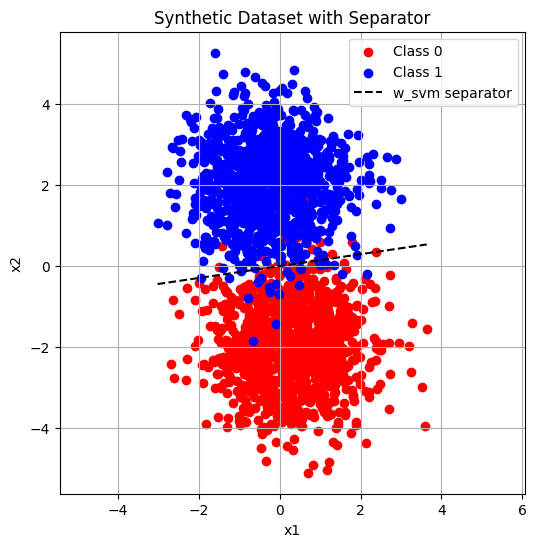

Dataset 2 — X shape: (25, 2000), Class counts: [1000 1000]


/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:152: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:152: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/.venv/lib/python3.11/site-packages/sklearn/decomposition/_base.py:152: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


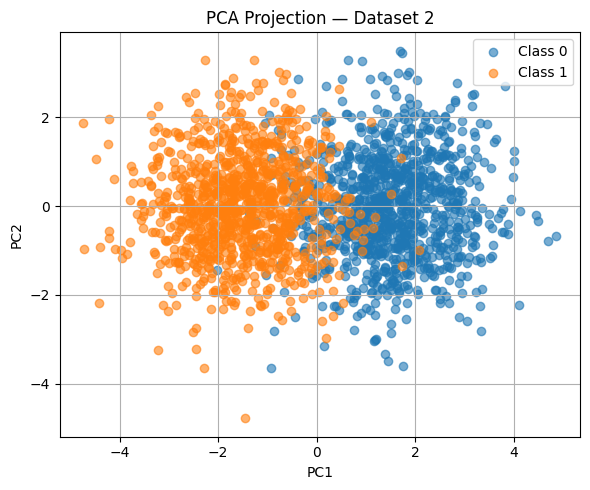

In [7]:
from aucopt.data.problem_svmdata import DataSet
from aucopt.eval.graphs import (
    plot_dataset_with_separator,
    plot_pca_projection,
)

# Define two dataset configs only
dataset_configs = [
    {"m": 2000, "n": 2, "sep_distance": 2.0, "noise": 0.1, "flip": 0.0},  # Low-dim binary
    {"m": 2000, "n": 25, "sep_distance": 1.5, "noise": 0.2, "flip": 0.0},  # High-dim + noise
]

datasets = []

for i, cfg in enumerate(dataset_configs):
    ds = DataSet(
        m=cfg["m"],
        n=cfg["n"],
        num_classes=2,
        class_ratios=[0.5, 0.5],
        sep_distance=cfg["sep_distance"],
        feature_noise=cfg["noise"],
        flip_ratio=cfg["flip"],
        seed=1034 + i  # vary seed per dataset
    )
    datasets.append(ds)

    print(f"Dataset {i+1} — X shape: {ds.X.shape}, Class counts: {np.bincount(ds.y)}")

    if ds.n == 2:
        plot_dataset_with_separator(ds)
    else:
        plot_pca_projection(ds.X, ds.y, title=f"PCA Projection — Dataset {i+1}")

### SGD Prox Implementation and Comparison with Baselines LibAUC/Pytorch

#### Prox-SGD Benchmark (No Visualization)

In [8]:
from aucopt.data.problem_instance import ProblemInstance
from aucopt.optim.variables import ALMParameters, SSNParameters, LineSearchParameters
from aucopt.optim.parameters import update_tol, update_iter, update_sigma_gamma, update_proxmethod
from aucopt.optim.sgd import run_prox_sgd_on_dataset
from aucopt.eval.graphs import *
from aucopt.eval.problem_summary import summarize_sample_efficiency
from aucopt.eval.baselines import evaluate_pytorch_bce, evaluate_libauc
from types import SimpleNamespace
import numpy as np
import os
import csv

# Helper to safely format AUC values
def safe_format(val):
    return f"{val:.4f}" if isinstance(val, float) else str(val)

# Ensure results directory exists
os.makedirs("results", exist_ok=True)

# Loop through both datasets
for i, ds in enumerate(datasets):
    dataset_name = f"sgd_dataset_{i+1}"
    print(f"\n=== Running Prox-SGD on {dataset_name} ===")

    # Step 1: Create train/test ProblemInstance
    PI = ProblemInstance(ds.X, ds.y, mode='train_test', train_ratio=0.7)

    # Step 2: ALM parameters
    AP = ALMParameters(max_iter_alm=30, tau_scale=0.9, sigma_scale=10.0, tol_alm=1e-6)
    SP = SSNParameters(tol_ssn=1e-6, max_iter_ssn=50)
    LS = LineSearchParameters(c=1e-4, max_iter_ls=15, beta=0.95)

    # Step 3: Run Prox-SGD
    n_epochs = 2
    n_batches = 5
    n_pos = 50
    n_neg = 50

    ds_train = SimpleNamespace(X=PI.X, y=PI.y)

    w = run_prox_sgd_on_dataset(
        ds=ds_train,
        AP=AP,
        SP=SP,
        LS=LS,
        dataset_name=dataset_name,
        n_epochs=n_epochs,
        n_batches=n_batches,
        n_pos=n_pos,
        n_neg=n_neg,
        sigma0=1.0,
        tau0=1e-5,
        alpha0=1.0,
        save_weights=True,
        plot_weights=False,
        output_dir="results"
    )

    # Step 4: Evaluate Prox-SGD AUC
    auc_sgd = evaluate_auc_on_test(w, PI, dataset_name=dataset_name)

    # Step 5: Summarize sample efficiency
    summarize_sample_efficiency(PI, n_epochs, n_batches, n_pos, n_neg, dataset_name=dataset_name)

    # Step 6: Prepare data for baselines
    X_train = PI.X.T
    y_train = PI.y
    X_test = PI.X_test.T
    y_test = PI.y_test

    # Step 7: Evaluate PyTorch BCE baseline
    auc_pytorch = evaluate_pytorch_bce(X_train, X_test, y_train, y_test)
    print(f"PyTorch BCE AUC for {dataset_name}: {safe_format(auc_pytorch)}")

    # Step 8: Evaluate LibAUC PESG baseline
    auc_libauc = evaluate_libauc(X_train, X_test, y_train, y_test)
    print(f"LibAUC PESG AUC for {dataset_name}: {safe_format(auc_libauc)}")

    # Step 9: Save AUC comparison
    csv_path = f"results/auc_comparison_{dataset_name}.csv"
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Method", "AUC"])
        writer.writerow(["Prox-SGD", safe_format(auc_sgd)])
        writer.writerow(["PyTorch BCE", safe_format(auc_pytorch)])
        writer.writerow(["LibAUC PESG", safe_format(auc_libauc)])
    print(f"✅ Saved AUC comparison to {csv_path}")



=== Running Prox-SGD on sgd_dataset_1 ===
Epoch 1
Epoch 2


/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: divide by zero encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: overflow encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: invalid value encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: divide by zero encountered in matmul
  proxvar.d_D = PI.D.T @ d
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: overflow encountered in matmul
  proxvar.d_D = PI.D.T @ d
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: inv

✅ Saved final weights to results/sgd_dataset_1_w_sgd.csv
Saved ROC plot to results/sgd_dataset_1_roc.png
Saved AUC value to results/sgd_dataset_1_auc.csv
Test AUC for sgd_dataset_1: 0.7928

--- Sample Efficiency Summary ---
Dataset: sgd_dataset_1
Total training samples available: 1400
Total samples used (SGD batches): 100 × 5 × 2 = 1000
PyTorch BCE AUC for sgd_dataset_1: 0.9951
LibAUC PESG AUC for sgd_dataset_1: 0.9920
✅ Saved AUC comparison to results/auc_comparison_sgd_dataset_1.csv

=== Running Prox-SGD on sgd_dataset_2 ===


/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: divide by zero encountered in matmul
  scores = w @ PI.X_test
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: overflow encountered in matmul
  scores = w @ PI.X_test
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: invalid value encountered in matmul
  scores = w @ PI.X_test


Epoch 1


/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: divide by zero encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: overflow encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: invalid value encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: divide by zero encountered in matmul
  proxvar.d_D = PI.D.T @ d
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: overflow encountered in matmul
  proxvar.d_D = PI.D.T @ d
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: inv

Epoch 2
✅ Saved final weights to results/sgd_dataset_2_w_sgd.csv
Saved ROC plot to results/sgd_dataset_2_roc.png
Saved AUC value to results/sgd_dataset_2_auc.csv
Test AUC for sgd_dataset_2: 0.7201

--- Sample Efficiency Summary ---
Dataset: sgd_dataset_2
Total training samples available: 1400
Total samples used (SGD batches): 100 × 5 × 2 = 1000
PyTorch BCE AUC for sgd_dataset_2: 0.9805
LibAUC PESG AUC for sgd_dataset_2: 0.9640
✅ Saved AUC comparison to results/auc_comparison_sgd_dataset_2.csv


/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: divide by zero encountered in matmul
  scores = w @ PI.X_test
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: overflow encountered in matmul
  scores = w @ PI.X_test
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: invalid value encountered in matmul
  scores = w @ PI.X_test


#### Prox-SGD with Proximal Geometry Visualization

In [ ]:
from aucopt.data.problem_instance import ProblemInstance
from aucopt.optim.variables import ALMParameters, SSNParameters, LineSearchParameters
from aucopt.optim.parameters import update_tol, update_iter, update_sigma_gamma, update_proxmethod
from aucopt.optim.sgd import run_prox_sgd_on_dataset
from aucopt.eval.graphs import *
from aucopt.eval.problem_summary import summarize_sample_efficiency
from aucopt.eval.baselines import evaluate_pytorch_bce, evaluate_libauc
from types import SimpleNamespace
import numpy as np
import os
import csv

# Helper to safely format AUC values
def safe_format(val):
    return f"{val:.4f}" if isinstance(val, float) else str(val)

# Ensure results directory exists
os.makedirs("results", exist_ok=True)

# Loop through both datasets
for i, ds in enumerate(datasets):
    dataset_name = f"sgd_dataset_{i+1}"
    print(f"\n=== Running Prox-SGD on {dataset_name} ===")

    # Step 1: Create train/test ProblemInstance
    PI = ProblemInstance(ds.X, ds.y, mode='train_test', train_ratio=0.7)

    # Step 2: ALM parameters
    AP = ALMParameters(max_iter_alm=30, tau_scale=0.9, sigma_scale=10.0, tol_alm=1e-6)
    SP = SSNParameters(tol_ssn=1e-6, max_iter_ssn=50)
    LS = LineSearchParameters(c=1e-4, max_iter_ls=15, beta=0.95)

    # Step 3: Visualize initial approximation (random w)
    f = plot_linear_indicator(delta=1.0, label="initial")
    random_w = np.random.randn(PI.X.shape[0])
    scatter_prox_points(random_w, lambda_vec=np.zeros(len(PI.K)), sigma=1.0, PI=PI, f=f, label="initial")
    plt.savefig(f"results/{dataset_name}_prox_init.png")
    plt.close()
    print(f"✅ Saved initial prox plot to results/{dataset_name}_prox_init.png")

    # Step 4: Run Prox-SGD
    n_epochs = 2
    n_batches = 5
    n_pos = 50
    n_neg = 50
    ds_train = SimpleNamespace(X=PI.X, y=PI.y)

    w = run_prox_sgd_on_dataset(
        ds=ds_train,
        AP=AP,
        SP=SP,
        LS=LS,
        dataset_name=dataset_name,
        n_epochs=n_epochs,
        n_batches=n_batches,
        n_pos=n_pos,
        n_neg=n_neg,
        sigma0=1.0,
        tau0=1e-5,
        alpha0=1.0,
        save_weights=True,
        plot_weights=False,
        output_dir="results"
    )

    # Step 5: Visualize final approximation (after training)
    f = plot_linear_indicator(delta=1.0, label="final")
    scatter_prox_points(w, lambda_vec=np.zeros(len(PI.K)), sigma=1.0, PI=PI, f=f, label="final")
    plt.savefig(f"results/{dataset_name}_prox_final.png")
    plt.close()
    print(f"✅ Saved final prox plot to results/{dataset_name}_prox_final.png")

    # Step 6: Evaluate Prox-SGD AUC
    auc_sgd = evaluate_auc_on_test(w, PI, dataset_name=dataset_name)

    # Step 7: Summarize sample efficiency
    summarize_sample_efficiency(PI, n_epochs, n_batches, n_pos, n_neg, dataset_name=dataset_name)

    # Step 8: Prepare data for baselines
    X_train = PI.X.T
    y_train = PI.y
    X_test = PI.X_test.T
    y_test = PI.y_test

    # Step 9: Evaluate PyTorch BCE baseline
    auc_pytorch = evaluate_pytorch_bce(X_train, X_test, y_train, y_test)
    print(f"PyTorch BCE AUC for {dataset_name}: {safe_format(auc_pytorch)}")
    

    # Step 10: Evaluate LibAUC PESG baseline
    auc_libauc = evaluate_libauc(X_train, X_test, y_train, y_test)
    print(f"LibAUC PESG AUC for {dataset_name}: {safe_format(auc_libauc)}")
    

    # Step 11: Save AUC comparison
    csv_path = f"results/auc_comparison_{dataset_name}.csv"
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Method", "AUC"])
        writer.writerow(["Prox-SGD", safe_format(auc_sgd)])
        writer.writerow(["PyTorch BCE", safe_format(auc_pytorch)])
        writer.writerow(["LibAUC PESG", safe_format(auc_libauc)])
    print(f"✅ Saved AUC comparison to {csv_path}")



=== Running Prox-SGD on sgd_dataset_1 ===
✅ Saved initial prox plot to results/sgd_dataset_1_prox_init.png
Epoch 1


/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: divide by zero encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: overflow encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: invalid value encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: divide by zero encountered in matmul
  proxvar.d_D = PI.D.T @ d
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: overflow encountered in matmul
  proxvar.d_D = PI.D.T @ d
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: inv

Epoch 2
✅ Saved final weights to results/sgd_dataset_1_w_sgd.csv
✅ Saved final prox plot to results/sgd_dataset_1_prox_final.png
Saved ROC plot to results/sgd_dataset_1_roc.png
Saved AUC value to results/sgd_dataset_1_auc.csv
Test AUC for sgd_dataset_1: 0.9872

--- Sample Efficiency Summary ---
Dataset: sgd_dataset_1
Total training samples available: 1400
Total samples used (SGD batches): 100 × 5 × 2 = 1000
PyTorch BCE AUC for sgd_dataset_1: 0.9950
LibAUC PESG AUC for sgd_dataset_1: 0.9940
📊 Saved AUC comparison plot to results/auc_comparison_sgd_dataset_1.png
✅ Saved AUC comparison to results/auc_comparison_sgd_dataset_1.csv

=== Running Prox-SGD on sgd_dataset_2 ===


/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: divide by zero encountered in matmul
  scores = w @ PI.X_test
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: overflow encountered in matmul
  scores = w @ PI.X_test
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: invalid value encountered in matmul
  scores = w @ PI.X_test


✅ Saved initial prox plot to results/sgd_dataset_2_prox_init.png
Epoch 1
Epoch 2


/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: divide by zero encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: overflow encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:27: RuntimeWarning: invalid value encountered in matmul
  ssnvar.w_ssn_D = PI.D.T @ ssnvar.w_ssn
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: divide by zero encountered in matmul
  proxvar.d_D = PI.D.T @ d
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: overflow encountered in matmul
  proxvar.d_D = PI.D.T @ d
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/optim/ssn.py:60: RuntimeWarning: inv

✅ Saved final weights to results/sgd_dataset_2_w_sgd.csv
✅ Saved final prox plot to results/sgd_dataset_2_prox_final.png
Saved ROC plot to results/sgd_dataset_2_roc.png
Saved AUC value to results/sgd_dataset_2_auc.csv
Test AUC for sgd_dataset_2: 0.9167

--- Sample Efficiency Summary ---
Dataset: sgd_dataset_2
Total training samples available: 1400
Total samples used (SGD batches): 100 × 5 × 2 = 1000
PyTorch BCE AUC for sgd_dataset_2: 0.9804


/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: divide by zero encountered in matmul
  scores = w @ PI.X_test
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: overflow encountered in matmul
  scores = w @ PI.X_test
/Users/nataliaa.rodriguez/Documents/Repositories/auc-opt/src/python/aucopt/eval/graphs.py:158: RuntimeWarning: invalid value encountered in matmul
  scores = w @ PI.X_test


LibAUC PESG AUC for sgd_dataset_2: 0.9763
📊 Saved AUC comparison plot to results/auc_comparison_sgd_dataset_2.png
✅ Saved AUC comparison to results/auc_comparison_sgd_dataset_2.csv
